# Решение задачи кластеризации торговых точек нейросетевыми методами

* [Тетрадка Егора](https://colab.research.google.com/drive/1AyiGImahqooigehAzoyOFR2FX1eFamik?usp=sharing#scrollTo=bo4utKnSOT9q) про каталог

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style='darkgrid')
filterwarnings('ignore')

## Загрузка и Базовая очистка данных (от дубликатов, нулей)

In [ ]:
df_product = pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/product_dict_df_sorted.csv', sep=';')
df_product.fillna('Неизвестный класс', inplace=True)
df_product.loc[df_product['PRODUCT_LVL_NM1'] == '04-10', 'PRODUCT_LVL_NM1'] = 'Неизвестный класс'
df_product[100:105]

,PRODUCT_ID,PRODUCT_NM,PRODUCT_LVL_NM1,PRODUCT_LVL_NM2,PRODUCT_LVL_NM3,PRODUCT_LVL_NM4,FAKE_ID
100,157448,Решетка радиаторная 600х1200 мм слон,Инженерные системы,Вентиляция,Вентиляция,Решетки радиаторные,100
101,75608,Лючок пластиковый 200х200 с защелкой,Инженерные системы,Вентиляция,Вентиляция,Лючки ревизионные,101
102,43328,Люк под плитку Слава 600х600 (ШхВ) станд,Инженерные системы,Вентиляция,Вентиляция,Лючки ревизионные,102
103,235018,Панель монтаж. для КСРМ 500х590 (уп.2шт),Инженерные системы,Вентиляция,Вентиляция,Комплексные системы вентиляции,103
104,84075,Решетка вентиляционная 600*600 нак.С-003,Инженерные системы,Вентиляция,Вентиляция,Решетки вентиляционные,104


Всего записей в исходном наборе данных:

In [ ]:
chunksize = 10 ** 6
counter = 0
for chunk in pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_sended.csv', sep=';', chunksize=chunksize):
    counter += chunk.shape[0]

counter

45605040

In [ ]:
chunk

,POS_ID,PICKUP_STORE_LOC_ID,PICKUP_DT,SALES_QTY,UNIT_BASE,SALES_QTY_BASE,FAKE_ID,REVENUE,FAKE_ID.1
45000000,2034624967,155,30DEC2019,0.376,KG,0.188,83191,96.82,83191
45000001,2034624967,155,30DEC2019,0.208,KG,0.104,88116,53.56,88116
45000002,2034624971,147,30DEC2019,2.000,ST,1.000,259601,424.50,259601
45000003,2034624978,244,30DEC2019,2.000,MSH,1.000,212979,508.34,212979
45000004,2034624979,237,30DEC2019,2.000,UP,1.000,223394,296.66,223394
...,...,...,...,...,...,...,...,...,...
45605035,2038026535,220,17JUL2020,12.000,MSH,6.000,228365,3500.00,228365
45605036,2038026535,220,17JUL2020,2.000,ST,1.000,50818,481.66,50818
45605037,2038026535,220,17JUL2020,2.000,ST,1.000,205088,924.34,205088
45605038,2038026538,157,16JUL2020,20.000,ST,10.000,223962,233.34,223962


### Нулевая выручка - удалить из подсчетов

In [ ]:
zero_revenue_trash = 0
for chunk in tqdm(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_sended.csv', sep=';', chunksize=chunksize)):
    zero_revenue_trash += (chunk['REVENUE'] == 0).sum()

46it [00:51,  1.12s/it]


In [ ]:
zero_revenue_trash

227665

### Таблица id чека - список товаров

* Сколько различных товарных чеков (POS_ID) встречается в записях?

* В скольких чеках встретилась определенная товарная позиция (FAKE_ID)?

Заведем два словаря: для каждого чека список его товарных позиций, для товара число раз, когда его купили.

In [ ]:
from collections import defaultdict

receipts = defaultdict(list)
goods = defaultdict(int)

chunksize = 10 ** 6
for chunk in tqdm(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_sended.csv', sep=';', chunksize=chunksize)):
    pos_ids = chunk['POS_ID']
    good_ids = chunk['FAKE_ID']
    for rec, good in zip(pos_ids, good_ids):
      receipts[rec] += [good]
      goods[good] += 1

46it [01:47,  2.34s/it]


In [ ]:
receipts[2029755112]

[227761, 83982, 209589, 41768, 227987, 93204]

**Итого,** в базе информация из 18,6 млн чеков по 43 358 товарам.

In [ ]:
import csv

# v = 0
# with open('/content/drive/MyDrive/CourseWorkSAS/receipts_items.csv', 'w') as File_write:
#   writer = csv.writer(File_write, delimiter=';')
#   writer.writerow(['POS_ID', 'FAKE_ID', 'GOOD_CATEG', 'STORE_ID', 'MONTH_DT', 'REVENUE'])
#   for r in tqdm(reader):
#       writer.writerow()
#       v += 1

### Расшифровка чека в читаемом виде

Ниже введена функция, переводящая список чисел - номеров sku_id в dataframe с названиями и исходными категориями соотвествующих товаров. Первая функция сопоставляет id с product_id продукта, вторая - с fake_id.

In [ ]:
# Индексы sku_id соотвествуют fake_id:
def read_receipt(ids, df_descr):
    descr_table = pd.DataFrame()
    for id in ids:
        id_descr = df_descr.loc[id]
        if id_descr.shape[0] == 0:
            print('Товар не найден, id = ', id)
        else:
            descr_table = descr_table.append(id_descr)
    return descr_table

Пример работы функции.

In [ ]:
read_receipt(receipts[2029755112], df_product)

,PRODUCT_ID,PRODUCT_NM,PRODUCT_LVL_NM1,PRODUCT_LVL_NM2,PRODUCT_LVL_NM3,PRODUCT_LVL_NM4,FAKE_ID
227761,275826.0,Губки для мытья посуды Оптима 96х64х27мм,Сопутствующие товары,Хозтовары,Хозтовары,"Тряпки, салфетки, губки",227761.0
83982,232614.0,"СММ 4,2х41 сверло SMMwD Yoko",Сопутствующие товары,Метизы и крепеж,Метизы,Саморезы с п/ш,83982.0
209589,141947.0,"Перчатки х/б, ПВХ 5 нитей",Сопутствующие товары,Средства защиты,Средства защиты,Средства защиты рук,209589.0
41768,269664.0,Шпатель резиновый 40мм белый,Сопутствующие товары,Инструмент ручной,Штукатурно-отделочный инструмент,Шпатели,41768.0
227987,36682.0,"Маркер перманентный, черный",Сопутствующие товары,Хозтовары,Хозтовары,Хозтовары прочее,227987.0
93204,205108.0,Дюбель полипропилен. 6х42 тип U потай,Сопутствующие товары,Метизы и крепеж,Метизы,Дюбели,93204.0


## **Обзор классификации товаров**

In [ ]:
df_product[5400:5405]

,PRODUCT_ID,PRODUCT_NM,PRODUCT_LVL_NM1,PRODUCT_LVL_NM2,PRODUCT_LVL_NM3,PRODUCT_LVL_NM4,FAKE_ID
5400,2100159,Счетчик гор воды с имп.вых ВСГд-20 с КМЧ,Инженерные системы,Водоснабжение и Водоотведение,Счетчики воды,Счетчики воды,5400
5401,250673,МП-Пресс Муфта с гайкой 16х1/2 Comap (уп,Инженерные системы,Водоснабжение и Водоотведение,Трубы МП и фитинги,МП пресс фитинги,5401
5402,82244,ПП Угольник бел. 45град. 75 ФД Пласт,Инженерные системы,Водоснабжение и Водоотведение,Трубы ПП и фитинги,ПП фитинги соединительные,5402
5403,160163,VT Кран под полипропилен с накидной гайк,Инженерные системы,Водоснабжение и Водоотведение,Краны шаровые бытовые,Краны шаровые Бытовые,5403
5404,82243,ПП Угольник бел. 45град. 50 ФД Пласт,Инженерные системы,Водоснабжение и Водоотведение,Трубы ПП и фитинги,ПП фитинги соединительные,5404


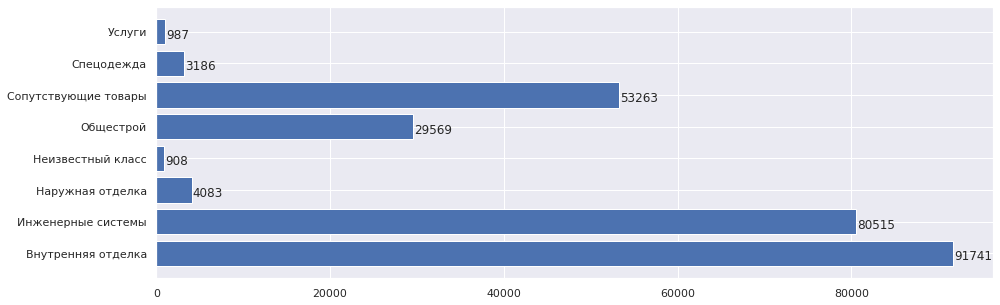

In [ ]:
lvl_1_count = df_product.groupby(['PRODUCT_LVL_NM1'])['FAKE_ID'].agg('count')

fig, ax = plt.subplots(figsize=(15, 5))
ax.barh(lvl_1_count.index, lvl_1_count.values)
for i, v in enumerate(lvl_1_count):
    ax.text(v + 100, i - .2, str(v))

In [ ]:
df_product['PRODUCT_LVL_NM1'].unique()

array(['Неизвестный класс', 'Инженерные системы', 'Общестрой',
       'Спецодежда', 'Внутренняя отделка', 'Наружная отделка',
       'Сопутствующие товары', 'Услуги'], dtype=object)

## Майнинг признаков магазинов

In [ ]:
categs = {'Неизвестный класс' : '0', 'Инженерные системы' : '1', 
          'Общестрой' : '2', 'Спецодежда' : '3',
          'Внутренняя отделка' : '4', 'Наружная отделка' : '5',
          'Сопутствующие товары' : '6', 'Услуги' : '7'}

In [ ]:
months = {'JAN' : '01', 'FEB' : '02', 'MAR' : '03', 'APR' : '04',
          'MAY' : '05', 'JUN' : '06', 'JUL' : '07', 'AUG' : '08',
          'SEP' : '09', 'OCT' : '10', 'NOV' : '11', 'DEC' : '12'}

def data_formatting(s: str):
    return s[5:] + '-' + months[s[2:5]] + '-' + s[:2]

def data_crop(s: str):
    if s == 'PICKUP_DT':
      return s
    return s[5:] + '_' + months[s[2:5]]

In [ ]:
for chunk in pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_sended.csv', sep=';', chunksize=chunksize):
    m = chunk['PICKUP_DT'].apply(lambda s: s[5:] + '-' + months[s[2:5]] + '-' + s[:2])
    print(m.min(), m.max())

2018-01-01 2021-05-12
2017-10-27 2021-05-12
2018-01-02 2021-05-12
2018-01-02 2021-05-12
2018-01-02 2021-05-12
2018-01-02 2021-05-12
2018-01-01 2021-05-12
2018-01-02 2021-05-12
2018-01-02 2021-05-12
2018-01-02 2021-05-12
2018-01-02 2021-05-12
2018-01-02 2021-05-12
2018-01-03 2021-05-12
2016-09-30 2021-05-12
2018-01-03 2021-05-12
2018-01-01 2021-08-14
2018-01-01 2021-05-12
2018-01-01 2021-05-12
2018-01-03 2021-05-12
2018-01-02 2021-05-12
2017-11-09 2021-05-12
2018-01-02 2021-05-12
2018-01-03 2021-05-12
2018-01-02 2021-05-12
2018-01-02 2021-05-12
2018-01-02 2021-05-12
2018-01-01 2021-05-12
2018-01-04 2021-05-12
2018-01-02 2021-05-12
2017-05-05 2021-05-12
2018-01-02 2021-05-12
2018-01-03 2021-05-12
2018-01-03 2021-05-12
2018-01-02 2021-05-12
2018-01-01 2021-05-12
2018-01-02 2021-05-12
2018-01-03 2021-05-12
2018-01-01 2021-05-12
2018-01-02 2021-05-12
2018-01-01 2021-05-12
2018-01-03 2021-05-12
2018-01-03 2021-05-12
2018-01-02 2021-05-12
2018-01-01 2021-05-12
2018-01-02 2021-05-12
2018-01-01

#### Количество чеков по категориям и периодам

In [ ]:
###
# Словарь: магазин - список чеков
###
stores = defaultdict(int)
for chunk in tqdm(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_sended.csv', sep=';', chunksize=10**6)):
    pos_ids = chunk['POS_ID']
    stores_ids = chunk['PICKUP_STORE_LOC_ID']
    for rec, place in zip(pos_ids, stores_ids):
      stores[place] += 1

46it [01:13,  1.60s/it]


In [ ]:
df_stores = pd.DataFrame.from_dict(stores, orient='index', columns=['rec_count'])
(df_stores['rec_count'] < 5000).sum()

75

In [ ]:
bigs = [ 24,  22, 124, 144, 131, 123, 121, 127,  23,  21, 154, 25, 244, 146, 153]
bigs = sorted(bigs)

missing_stores = [258, 169, 62, 180, 268, 175, 267, 66, 168, 172, 257, 176, 179, 
                  44, 270, 78, 69, 275, 73, 65, 1007, 71, 8806, 77, 182, 74, 67,
                  264, 72, 171, 272, 76, 173, 63, 266, 68, 273, 183]

In [ ]:
# main_stores_stat = df_stores.sort_values(by='rec_count', ascending=False)[:154]
# main_stores = sorted(main_stores_stat.index)
# for st in [62, 66, 168, 169, 172, 175, 176, 179, 180, 257, 258, 267, 268, 270]:
#   main_stores.pop(main_stores.index(st))

In [ ]:
main_stores = pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_140stores_500items.csv', sep=';', index_col='Unnamed: 0').columns

In [ ]:
df_store_info = pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/StoresDirectory.csv', index_col='StoreID')
df_store_info.loc[main_stores]

,StoreName,StoreType,StoreArea
StoreID,,,
21,"БМ Тмн, 50 Лет Октября, 109",БИГ,676.80
22,"БМ Тмн, Панфиловцев 86/1",БИГ,689.44
23,"БМ Тмн, Пермякова, 2 к1",БИГ,417.89
24,"БМ Тмн, Щербакова, 99",БИГ,421.84
25,"БМ Тмн, Домостроителей, 32",БИГ,662.63
...,...,...,...
5501,БМ Тмн Ставропольская 120 к2,БИГ,808.43
6501,МОК Екб мкр Светлый 3,МОК,76.20
6701,МОК Тмн Олимпийская 31,МОК,96.00


#### Выручка по периодам и категориям

Выделим признаки для месяцев с января 2018 по апрель 2021, предметы сгруппируем по 8 категориям верхнего уровня.

Примеры названий:

revenue_7_2018_05

cnt_7_2018_05

In [ ]:
month_strs = []
for y in range(2018, 2022):
    for mon in range(1, 13):
        if y == 2021 and mon == 5: 
            break
        strm = str(mon) if mon > 9 else '0' + str(mon)
        month_strs += [str(y) + '_' + strm]
month_strs[-5:]

['2020_12', '2021_01', '2021_02', '2021_03', '2021_04']

In [ ]:
for mon in month_strs:
  for categ in range(8):
    df_stores['revenue_' + str(categ) + '_' + mon] = np.zeros(247)
    # df_stores['cnt_' + str(categ) + '_' + mon] = np.zeros(247)

df_stores.head()

,rec_count,revenue_0_2018_01,revenue_1_2018_01,revenue_2_2018_01,revenue_3_2018_01,revenue_4_2018_01,revenue_5_2018_01,revenue_6_2018_01,revenue_7_2018_01,revenue_0_2018_02,...,revenue_6_2021_03,revenue_7_2021_03,revenue_0_2021_04,revenue_1_2021_04,revenue_2_2021_04,revenue_3_2021_04,revenue_4_2021_04,revenue_5_2021_04,revenue_6_2021_04,revenue_7_2021_04
129,350359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,268252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,317273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130,358758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,845969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# for chunk in tqdm(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_categ_months_revenue.csv', sep=';', chunksize=10**6)):
#     for store_id in df_stores.index:
#         for categ in range(8):
#             df_curr = chunk.loc[(chunk['GOOD_CATEG'] == categ) & (chunk['STORE_ID'] == store_id), ['MONTH_DT', 'REVENUE']]
#             for mon in month_strs:
#                 sum_value = df_curr.loc[(df_curr['MONTH_DT'] == mon), 'REVENUE'].sum()
#                 df_stores.loc[store_id, 'revenue_' + str(categ) + '_' + mon] += sum_value

46it [43:29, 56.73s/it]


In [ ]:
col_names = {
    'rev_0' : ['revenue_0_' + mon for mon in month_strs],
    'rev_1' : ['revenue_1_' + mon for mon in month_strs],
    'rev_2' : ['revenue_2_' + mon for mon in month_strs],
    'rev_3' : ['revenue_3_' + mon for mon in month_strs],
    'rev_4' : ['revenue_4_' + mon for mon in month_strs],
    'rev_5' : ['revenue_5_' + mon for mon in month_strs],
    'rev_6' : ['revenue_6_' + mon for mon in month_strs],
    'rev_7' : ['revenue_7_' + mon for mon in month_strs]
    }

In [ ]:
df_stores[['rec_count'] + col_names['rev_1']][:10]

,rec_count,revenue_1_2018_01,revenue_1_2018_02,revenue_1_2018_03,revenue_1_2018_04,revenue_1_2018_05,revenue_1_2018_06,revenue_1_2018_07,revenue_1_2018_08,revenue_1_2018_09,...,revenue_1_2020_07,revenue_1_2020_08,revenue_1_2020_09,revenue_1_2020_10,revenue_1_2020_11,revenue_1_2020_12,revenue_1_2021_01,revenue_1_2021_02,revenue_1_2021_03,revenue_1_2021_04
129,350359,733413.96,714143.74,553315.84,802250.42,1135512.24,1237357.28,1378073.86,1404924.24,1472601.64,...,2169945.58,1986885.16,2381663.20,2197663.44,1681608.96,1546799.46,1427280.96,1220828.14,1508943.10,1751028.92
46,268252,927563.96,665164.76,746204.86,914836.58,1264118.06,1340742.80,1269568.48,1459626.60,1277517.26,...,1191781.12,1020190.08,1098007.18,1192635.70,777683.92,984661.58,912960.36,738996.44,1090807.86,1010932.20
125,317273,1194867.74,1299332.46,1150429.90,1336317.54,1306231.00,1579099.60,1746014.96,2019318.20,1783689.44,...,2506695.10,1895555.70,1770741.66,1922306.04,1714900.50,1908443.94,1304944.34,1367349.08,1506066.78,1722546.14
130,358758,1067969.78,1167235.54,1087280.30,1207028.94,1540627.42,1191961.30,1457454.50,1172001.98,1560546.24,...,2479861.00,2043399.08,2125029.78,1937207.60,1829025.38,1803869.68,2106909.84,1958662.90,2203637.36,2118512.56
24,845969,1062645.96,996930.60,938634.46,1323042.42,1322777.60,1579646.20,1670135.98,1650452.12,1597007.30,...,10568192.42,10385675.04,11050016.56,11509780.42,9371161.38,9504694.30,9514868.66,7275936.52,7559371.46,7941589.92
120,404693,1190437.08,1310109.84,1190163.08,1551352.24,1436113.42,1956076.96,1740168.88,1966931.42,1718645.78,...,3248194.62,2727429.74,2231883.02,2368305.18,2439340.84,2835561.70,2082844.40,2591763.40,3517360.36,2948860.56
23,489528,1840990.52,1512196.44,1698578.64,1737270.82,2202120.50,2299746.86,2794516.88,2775962.92,2843438.92,...,4282897.12,3706035.56,3555833.32,3691889.06,3107757.86,3440701.06,3466478.66,2975040.66,3404218.20,3420555.68
45,205666,364739.28,417383.84,404561.12,423656.28,610139.60,962587.36,792034.96,721129.70,862474.52,...,843177.86,834773.50,782482.72,805391.40,820677.82,866091.48,717447.72,831898.54,681854.90,818139.50
22,775722,3196192.72,2685317.38,2868647.56,3345300.80,4388790.20,4829252.12,5642865.70,6470105.86,6114931.26,...,7356722.58,5624370.88,6090728.74,6534113.92,4916608.72,5884711.26,5160817.82,4024992.72,4456752.52,4794204.14
121,523320,1950155.36,1540003.54,1466336.20,1830124.76,2501885.16,2687545.56,2674853.40,3022713.64,3310056.74,...,4418814.68,3579290.24,3780011.22,4212016.34,3582962.22,3486868.40,3315815.22,2468636.40,2933618.20,3150093.78


In [ ]:
df_stores.to_csv('/content/drive/MyDrive/CourseWorkSAS/df_stores_revenues.csv', sep=';')

#### Цена за единицу товарной позиции

In [ ]:
df_items = pd.DataFrame()
for chunk in pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_sended.csv', sep=';', chunksize=chunksize):
    df_items = chunk
    break

НАДО ДЛЯ ВСЕЙ ТАБЛИЦЫ ДОБАВЛЯТЬ

In [ ]:
df_items.drop('FAKE_ID.1', 1, inplace=True)
df_items['PRICE'] = df_items['REVENUE'] / df_items['SALES_QTY_BASE']
df_items

,POS_ID,PICKUP_STORE_LOC_ID,PICKUP_DT,SALES_QTY,UNIT_BASE,SALES_QTY_BASE,FAKE_ID,REVENUE,PRICE
0,2030069017,129,04MAY2019,2.000,ST,1.000,59180,105.00,105.000000
1,2030069018,46,04MAY2019,0.896,KG,0.448,82691,1.02,2.276786
2,2030069020,125,04MAY2019,2.000,MSH,1.000,212269,739.20,739.200000
3,2030069021,130,04MAY2019,2.000,ST,1.000,205772,110.00,110.000000
4,2030069022,24,04MAY2019,12.000,M,12.000,16505,1129.20,94.100000
...,...,...,...,...,...,...,...,...,...
999995,2029755112,131,15APR2019,8.000,PAA,4.000,209589,133.34,33.335000
999996,2029755112,131,15APR2019,2.000,ST,1.000,41768,30.00,30.000000
999997,2029755112,131,15APR2019,2.000,ST,1.000,227987,53.34,53.340000
999998,2029755112,131,15APR2019,40.000,ST,20.000,93204,49.66,2.483000


### Количество проданного понедельно и по категориям

In [ ]:
# количество проданного понедельно

# сначала надо получить список недель датами

In [ ]:
import pandas as pd
import datetime as dt
from datetime import datetime

daterange_from = pd.date_range(datetime.strptime('2017-12-26', '%Y-%m-%d'), freq='W-MON', periods=118)
daterange_to = pd.date_range(datetime.strptime('2018-01-01', '%Y-%m-%d'), freq='W-SUN', periods=118)

datestr_from = [date_obj.strftime('%Y-%m-%d') for date_obj in daterange_from]
datestr_to = [date_obj.strftime('%Y-%m-%d') for date_obj in daterange_to]

In [ ]:
datestr_from[0], datestr_from[-1], datestr_to[0], datestr_to[-1]

('2018-01-01', '2020-03-30', '2018-01-07', '2020-04-05')

In [ ]:
currday = datetime.strptime('2018-01-04', '%Y-%m-%d')
mon = currday - dt.timedelta(days=currday.weekday())
mon.strftime('%Y-%m-%d')

'2018-01-01'

In [ ]:
chunk['SALES_QTY_BASE'].value_counts()

1.000      553676
2.000      143463
3.000       46732
4.000       39902
10.000      26735
            ...  
76.738          1
43.697          1
3.308           1
19.516          1
532.032         1
Name: SALES_QTY_BASE, Length: 14685, dtype: int64

In [ ]:
import csv

# v = 0
# with open('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_sended.csv', 'r') as File_read:
#   with open('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_lvl1_categ.csv', 'w') as File_write:
#     reader = csv.reader(File_read, delimiter=';')
#     writer = csv.writer(File_write, delimiter=';')
#     writer.writerow(['POS_ID', 'FAKE_ID', 'LVL1_CATEG', 'STORE_ID', 'PICKUP_DT', 'SALES_QTY_BASE'])
#     for r in tqdm(reader):
#         if v > 0:
#             lvl_name = df_product.loc[int(r[6]), 'PRODUCT_LVL_NM1']
#             c_num = categs[lvl_name]
#             writer.writerow([r[0], r[6], c_num, r[1], r[2], r[5]])
#         v += 1

In [ ]:
months = {'JAN' : '01', 'FEB' : '02', 'MAR' : '03', 'APR' : '04',
          'MAY' : '05', 'JUN' : '06', 'JUL' : '07', 'AUG' : '08',
          'SEP' : '09', 'OCT' : '10', 'NOV' : '11', 'DEC' : '12'}

def data_extract(s: str):
    return s[5:] + '-' + months[s[2:5]] + '-' + s[:2]

def monday_align(ugly_date):
    currday = datetime.strptime(data_extract(ugly_date), '%Y-%m-%d')
    mon = currday - dt.timedelta(days=currday.weekday())
    return mon.strftime('%Y-%m-%d')

In [ ]:
monday_align('05JAN2018')

'2018-01-01'

In [ ]:
# создаем dataframe ответа
# столбцы - названия категорий
# индекс строки - неделя, номер магазина

categs = {'Неизвестный класс' : '0', 'Инженерные системы' : '1', 
          'Общестрой' : '2', 'Спецодежда' : '3',
          'Внутренняя отделка' : '4', 'Наружная отделка' : '5',
          'Сопутствующие товары' : '6', 'Услуги' : '7'}

iterables = [datestr_from, main_stores]
mltindex = pd.MultiIndex.from_product(iterables, names=["week", "store"])

final_df = pd.DataFrame(columns=range(8), index=mltindex)
final_df.fillna(0, inplace=True)
final_df.head(3)

### Признаки встречаемости в чеках

In [ ]:
main_stores = list(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_140stores_500items.csv', sep=';', index_col='Unnamed: 0').columns.astype(int))
popular_products = list(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_140stores_500items.csv', sep=';', index_col='Unnamed: 0').index.astype(int))
main_stores_set = set(main_stores)
popular_prods_set = set(popular_products)

In [ ]:
months = {'JAN' : 1, 'FEB' : 2, 'MAR' : 3, 'APR' : 4,
          'MAY' : 5, 'JUN' : 6, 'JUL' : 7, 'AUG' : 8,
          'SEP' : 9, 'OCT' : 10, 'NOV' : 11, 'DEC' : 12}

def calc_yearhalf(date_str):
  m = months[date_str[2:5]]
  y = int(date_str[5:])
  return 2 * (y - 2018) + int(m > 6)

In [ ]:
calc_yearhalf('31NOV2019')

3

In [ ]:
item_freq = dict()
item_quants = dict()
item_revenue = dict()
dates = defaultdict(list)

for item in sorted(popular_products):
    item_freq[item] = np.array([[0] * 140] * 6)
    item_quants[item] = np.array([[0] * 140] * 6)
    item_revenue[item] = np.array([[0.0] * 140] * 6)

for chunk in tqdm(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_sended.csv', sep=';', chunksize=10**6)):
  for i, row in chunk.iterrows():
    if row['FAKE_ID'] in popular_prods_set and row['PICKUP_STORE_LOC_ID'] in main_stores_set:
      y = int(row['PICKUP_DT'][5:])
      if y > 2017 and y < 2021:
        yearhalf = calc_yearhalf(row['PICKUP_DT'])
        dates[yearhalf].append(row['PICKUP_DT'])
        ind = main_stores.index(row['PICKUP_STORE_LOC_ID'])
        item_freq[row['FAKE_ID']][yearhalf, ind] += 1
        item_quants[row['FAKE_ID']][yearhalf, ind] += abs(row['SALES_QTY_BASE'])
        item_revenue[row['FAKE_ID']][yearhalf, ind] += abs(row['REVENUE'])

46it [49:50, 65.01s/it]


In [ ]:
item_revenue_0 = dict()
item_revenue_1 = dict()
item_revenue_2 = dict()
item_revenue_3 = dict()
item_revenue_4 = dict()
item_revenue_5 = dict()

for item in popular_products:
    item_revenue_0[item] = item_revenue[item][0]
    item_revenue_1[item] = item_revenue[item][1]
    item_revenue_2[item] = item_revenue[item][2]
    item_revenue_3[item] = item_revenue[item][3]
    item_revenue_4[item] = item_revenue[item][4]
    item_revenue_5[item] = item_revenue[item][5]

In [ ]:
df_freq = pd.DataFrame.from_dict(item_revenue_5, orient='index', columns=main_stores)
df_freq.to_csv('/content/drive/MyDrive/CourseWorkSAS/revenues/df_revenue_yearhalf_5.csv', sep=';')

In [ ]:
pd.DataFrame.from_dict(item_freq_5, orient='index', columns=main_stores)

,21,22,23,24,25,26,27,28,29,32,...,3106,3301,4401,4502,4601,5501,6501,6701,8401,8403
221,90,133,147,170,75,0,5,103,9,5,...,0,10,0,0,0,0,0,0,0,0
405,107,100,118,199,111,43,20,200,54,16,...,0,1,1,2,0,0,0,0,0,0
410,99,124,97,162,75,30,12,66,20,4,...,0,11,2,1,1,0,0,0,0,0
506,47,66,71,102,45,38,6,98,51,6,...,0,1,0,1,0,0,0,0,0,0
507,86,128,168,159,66,34,8,157,42,11,...,0,8,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259313,248,54,118,242,130,233,107,348,191,43,...,0,11,2,3,1,0,1,0,0,0
259718,292,123,145,212,100,94,60,201,80,20,...,0,7,1,3,1,0,1,0,0,0
260634,135,195,155,246,180,146,44,2,79,32,...,0,7,2,4,1,0,0,0,0,0
262752,146,267,329,365,249,245,178,243,237,54,...,0,5,0,0,2,0,0,0,0,0


In [ ]:
item_freq_sum = {item : sum(mags) for item, mags in item_freq.items()}
popular_products = list(reversed(sorted(item_freq_sum, key=item_freq_sum.get)))[:500]

In [ ]:
popular_products = sorted(popular_products)

In [ ]:
item_freq_pop = dict()
for item in popular_products:
    item_freq_pop[item] = item_freq[item]

In [ ]:
df_big_popular = pd.DataFrame.from_dict(item_freq_pop, orient='index', columns=main_stores)
df_big_popular

,21,22,23,24,25,26,27,28,29,32,...,3106,3301,4401,4502,4601,5501,6501,6701,8401,8403
221,498,836,845,869,539,7,50,500,44,12,...,1,14,6,19,9,40,2,8,5,3
405,525,722,679,1124,625,295,134,783,346,24,...,2,3,7,23,8,24,14,4,11,9
410,597,681,490,930,398,150,77,365,144,9,...,4,12,7,20,7,38,8,5,5,5
506,350,553,552,774,289,228,66,416,284,12,...,1,3,5,17,2,21,5,3,8,6
507,524,924,1013,1111,606,173,82,712,249,18,...,4,11,8,24,9,39,11,6,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259313,2498,1128,1357,2135,1274,1367,636,1606,1054,81,...,44,28,54,99,21,36,63,56,26,9
259718,2358,1113,918,1437,797,563,393,883,535,35,...,16,15,27,51,15,57,9,10,17,2
260634,677,1162,673,1289,783,621,240,74,434,51,...,20,12,32,51,50,26,27,25,15,12
262752,1448,2150,1728,2419,1580,1352,989,1551,1415,109,...,15,13,60,93,46,37,39,42,34,15


In [ ]:
df_big_popular.to_csv('/content/drive/MyDrive/CourseWorkSAS/df_140stores_500items.csv', sep=';')

Признаки количества в базовых ЕИ

In [ ]:
main_stores = list(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_140stores_500items.csv', sep=';', index_col='Unnamed: 0').columns.astype(int))
popular_products = list(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_140stores_500items.csv', sep=';', index_col='Unnamed: 0').index.astype(int))
main_stores_set = set(main_stores)

In [ ]:
item_quants = dict()
item_revenue = dict()
for item in sorted(df_product['FAKE_ID']):
    item_quants[item] = [0] * 140
    item_revenue[item] = [0.0] * 140

for chunk in tqdm(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_sended.csv', sep=';', chunksize=10**6)):
  for i, row in chunk.iterrows():
    if row['PICKUP_STORE_LOC_ID'] in main_stores_set:
      pos = main_stores.index(row['PICKUP_STORE_LOC_ID'])
      item_quants[row['FAKE_ID']][pos] += abs(row['SALES_QTY_BASE'])
      item_revenue[row['FAKE_ID']][pos] += abs(row['REVENUE'])

46it [53:03, 69.20s/it]


In [ ]:
item_quant_pop = dict()
for item in popular_products:
    item_quant_pop[item] = item_quants[item]

In [ ]:
df_main_quants = pd.DataFrame.from_dict(item_quant_pop, orient='index', columns=main_stores)
df_main_quants

,21,22,23,24,25,26,27,28,29,32,...,3106,3301,4401,4502,4601,5501,6501,6701,8401,8403
221,609.0,1019.00,1025.00,1042.00,661.000,9.0,55.00,552.0,49.0,12.0,...,1.0,16.0,8.0,20.0,11.0,53.0,2.0,10.0,8.0,3.0
405,556.0,767.00,709.00,1180.00,657.044,303.0,137.00,810.0,375.0,24.0,...,3.0,3.0,7.0,23.0,8.0,25.0,14.0,4.0,12.0,9.0
410,940.0,1189.00,831.00,1485.00,673.000,210.0,97.00,602.0,216.0,12.0,...,4.0,16.0,10.0,33.0,15.0,72.0,14.0,6.0,7.0,5.0
506,417.0,650.00,656.00,925.00,352.000,287.0,72.00,474.0,339.0,15.0,...,1.0,4.0,5.0,18.0,4.0,24.0,5.0,3.0,10.0,6.0
507,757.0,1368.00,1490.00,1584.00,879.000,218.0,104.00,1030.0,360.0,24.0,...,4.0,17.0,10.0,36.0,13.0,68.0,15.0,9.0,12.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259313,50069.5,17308.10,20151.06,28256.73,14810.450,12077.3,5771.90,15144.5,9400.0,539.0,...,242.5,309.8,359.5,868.0,512.0,451.0,296.0,384.0,420.0,86.0
259718,62141.5,18695.40,18468.00,23556.30,9979.900,5124.8,4298.50,9552.1,5654.0,301.0,...,184.0,263.0,197.0,611.5,167.0,1247.0,53.0,76.5,164.0,32.0
260634,980.0,1577.00,907.00,1768.00,1006.000,761.0,283.00,89.0,538.0,64.0,...,23.0,14.0,41.0,62.0,89.0,39.0,27.0,31.0,15.0,14.0
262752,2288.0,3068.00,2369.00,3416.00,2050.000,1691.0,1156.00,1869.0,1657.0,144.0,...,15.0,15.0,68.0,108.0,63.0,49.0,39.0,44.0,41.0,18.0


In [ ]:
df_main_quants.to_csv('/content/drive/MyDrive/CourseWorkSAS/df_140stores_500quants.csv', sep=';')

 И 
Признаки выручки по 500 товарам

In [ ]:
item_rev_pop = dict()
for item in popular_products:
    item_rev_pop[item] = item_revenue[item]

In [ ]:
df_main_revenue = pd.DataFrame.from_dict(item_rev_pop, orient='index', columns=main_stores)
df_main_revenue

,21,22,23,24,25,26,27,28,29,32,...,3106,3301,4401,4502,4601,5501,6501,6701,8401,8403
221,131736.66,214870.40,226352.88,239664.10,139431.82,2970.84,11735.48,124619.08,16410.50,4669.46,...,341.34,4767.98,2473.32,9771.64,2781.64,22009.66,553.32,4171.62,2828.32,661.82
405,119200.08,160984.50,154409.96,271037.26,146907.72,65552.86,29910.74,189228.04,88148.90,8830.40,...,1104.06,1291.04,3172.68,9240.86,1819.66,11055.82,4400.02,1876.68,5079.50,2506.20
410,172054.72,219817.80,161885.50,286727.38,128905.12,42092.70,20146.62,115115.24,42500.60,3969.42,...,1189.60,3801.54,3362.80,12402.60,2914.66,24746.88,5111.86,2320.00,2666.66,1504.04
506,95079.30,140015.20,145993.52,205046.00,76639.42,69091.00,16002.22,116710.02,78114.94,5173.38,...,291.66,875.30,2241.68,7985.68,780.00,9231.56,1413.32,1315.02,3718.34,1538.32
507,175787.86,311156.28,359600.02,381366.06,206268.76,55949.34,23785.16,267688.64,92609.96,9062.54,...,1271.32,4842.08,3967.46,17228.16,3049.14,30061.52,4491.66,4377.52,5111.70,3660.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259313,1689132.26,584191.98,673138.30,996936.90,501299.54,419211.02,198326.74,543442.92,332117.70,18413.90,...,9686.62,13884.26,14200.50,35648.68,17367.72,17121.52,14070.62,16613.52,18127.48,3155.40
259718,1236659.88,367928.24,392854.46,471735.40,208576.44,109540.16,88644.18,217812.66,130569.30,9860.76,...,6729.28,9241.50,8191.32,24890.44,4564.36,45568.74,1963.34,3576.00,6661.68,1220.00
260634,92261.30,146218.96,91249.04,164630.30,97093.68,75281.20,27944.44,7831.86,52653.72,7275.42,...,2723.50,1703.18,4745.04,6920.18,10993.30,4346.34,3154.74,3590.54,1723.30,1656.72
262752,122515.98,174412.42,136464.10,195772.78,117938.74,99538.66,68577.96,107329.58,100478.02,10571.42,...,1300.94,1028.10,5537.34,8714.72,5158.20,3629.76,3235.20,3651.02,3285.02,1438.88


In [ ]:
df_main_revenue.to_csv('/content/drive/MyDrive/CourseWorkSAS/df_140stores_500revenue.csv', sep=';')

## Понедельная сборка

In [ ]:
items_set = set(popular_products)
shops_set = set(bigs)
date_matching = dict()

for chunk in tqdm(pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_fakeid_sended.csv', sep=';', chunksize=10**6)):
  for i, row in chunk.iterrows():
      if row['PICKUP_STORE_LOC_ID'] not in shops_set: # big shop
          continue
      if row['FAKE_ID'] not in items_set:             # popular item
          continue
      mon_date = ''
      if row['PICKUP_DT'] in date_matching:
          mon_date = date_matching[row['PICKUP_DT']]
      else:
          mon_date = monday_align(row['PICKUP_DT'])
          date_matching[row['PICKUP_DT']] = mon_date
      if mon_date < '2018-01-01' or mon_date > '2020-03-30':
          continue
      # bin search
      l, r = 0, 500
      while l < r - 1:
        m = (l + r) // 2
        if row['FAKE_ID'] < popular_products[m]:
            r = m
        else:
            l = m
      if popular_products[l] != row['FAKE_ID']:
        print('alarm')
      final_dict[(mon_date, row['PICKUP_STORE_LOC_ID'])][l] += row['REVENUE']

46it [44:38, 58.22s/it]


In [ ]:
iterables = [datestr_from, bigs]
mltindex = pd.MultiIndex.from_product(iterables, names=["WEEK", "STORE_ID"])

final_df = pd.DataFrame(data=final_dict.values(), columns=popular_products, index=mltindex)
final_df.head(5)

221     405      410     506     507      746     978     \
WEEK       STORE_ID                                                             
2018-01-01 21        503.40  271.52  1052.54  164.40   380.0  1812.88  305.08   
           22          0.00  431.40   419.32  591.84   360.0   932.32  457.62   
           23        186.44  407.28   549.14    0.00   180.0  1456.78    0.00   
           24        171.52  150.84   549.16  164.40   740.0   906.44  616.94   
           25        540.68  844.72   549.16  470.20   972.0  1780.50  959.32   

                      1207    1532     1882    ...  256746  256861   258055  \
WEEK       STORE_ID                            ...                            
2018-01-01 21        1308.82  151.02     0.00  ...  117.46  752.54  5949.84   
           22        3344.74  295.08   324.92  ...   43.90  267.36   448.48   
           23           0.00  318.82     0.00  ...  760.52  457.80  1793.90   
           24         668.94  318.82  1696.80  ...   32.04  597.68  2657.62   
           25        1454.24  151.02   696.76  ...  208.82  151.02  7408.14   

                     258580   259313   259718  260634  261354  262752   263059  
WEEK       STORE_ID                                                             
2018-01-01 21        466.10  5207.00  2227.12  374.40  255.94  542.40  1838.16  
           22        966.30  3333.68   583.06  367.24  425.44  101.70  1372.90  
           23        161.02  1893.22  2366.12  169.50  967.44  203.40  2079.68  
           24        398.32  3816.14  1894.10  159.32  946.96  296.64   915.28  
           25        659.60   280.16   279.66  302.72  486.28  635.66   686.46  

[5 rows x 500 columns]

In [ ]:
(final_df == 0).sum(axis=0)

221       123
405       125
410       138
506       207
507        76
         ... 
259718    103
260634     97
261354    167
262752     73
263059    128
Length: 500, dtype: int64

In [ ]:
final_df.to_csv('/content/drive/MyDrive/CourseWorkSAS/df_pop_week_revenue.csv', sep=';')

In [ ]:
final_df[87251].sum()

14962426.917

In [ ]:
df_big_popular.loc[87251].sum()

35263

In [ ]:
df_product.loc[87251]

PRODUCT_ID                                        70120
PRODUCT_NM         Саморез п/металлу TN 3,5х25 мм Knauf
PRODUCT_LVL_NM1                    Сопутствующие товары
PRODUCT_LVL_NM2                         Метизы и крепеж
PRODUCT_LVL_NM3                                  Метизы
PRODUCT_LVL_NM4                     Саморезы по металлу
FAKE_ID                                           87251
Name: 87251, dtype: object

In [ ]:
read_receipt(chunk[chunk['UNIT_BASE'] == 'UP']['FAKE_ID'].values[:10], df_product)

,PRODUCT_ID,PRODUCT_NM,PRODUCT_LVL_NM1,PRODUCT_LVL_NM2,PRODUCT_LVL_NM3,PRODUCT_LVL_NM4,FAKE_ID
223394,238272.0,"Мешки для мусора 120л, рул/25шт 40мкм",Сопутствующие товары,Хозтовары,Хозтовары,Мешки для строительного мусора,223394.0
159240,58775.0,Брикеты топливные 12 шт. Pini-Kay,Общестрой,Пиломатериал и погонажные изделия,Пиломатериал и погонажные изделия,Дрова,159240.0
160840,170066.0,Евродрова РУФ уп. 12 шт. 10 кг,Общестрой,Пиломатериал и погонажные изделия,Пиломатериал и погонажные изделия,Дрова,160840.0
219860,49008.0,Пленка полиэтилен. фас. ТУ 60мкр (3х10м),Общестрой,Теплоизоляция,"Изоляционный, укрывочный материал",Укрывочный материал,219860.0
223394,238272.0,"Мешки для мусора 120л, рул/25шт 40мкм",Сопутствующие товары,Хозтовары,Хозтовары,Мешки для строительного мусора,223394.0
43152,5831.0,"Набор для газовой пайки 58кВт, 1 насадка",Сопутствующие товары,Инструмент ручной,Инструмент специализированный,Инструмент специализированный прочий,43152.0
100391,123296.0,Угол внутренний Wimar 58мм Дуб ведре 2ш,Внутренняя отделка,Напольные покрытия,Плинтусы и комплектующие,Углы для плинтусов,100391.0
124738,123250.0,Заглушки Wimar 58мм Дуб ведре 2ш,Внутренняя отделка,Напольные покрытия,Плинтусы и комплектующие,Заглушки для плинтусов,124738.0
91313,32300.0,Хомут обжимной 25х40 (2 шт),Сопутствующие товары,Метизы и крепеж,Такелаж,Хомуты червячные,91313.0
241699,33162.0,"Бита с торцевой головкой 8х45мм, 2шт",Сопутствующие товары,Электроинструмент и расходники,Биты,Насадки-биты,241699.0


In [ ]:
chunk['UNIT_BASE'].value_counts()

ST     456932
UP      47750
MSH     31668
KG      17492
PAA     13575
M        9853
LST      7651
PM       5334
VDR      3964
ROL      3892
KMP      2808
BAG      1425
10        827
L         729
M2        600
BN        215
KAR       144
TJK        58
MKR        56
BCH        29
MST        28
TO          6
PAL         4
Name: UNIT_BASE, dtype: int64